In [1]:
from Utility import gradient_first
from Solver_q import load_netcdf, preprocess_data
import numpy as np
import scipy.io
import scipy.ndimage
import matplotlib.pyplot as plt
import pickle
from NeuralNet import *
from timeit import default_timer

ny = 256
L = 32
yy, dy = np.linspace(0, L - L/ny, ny), L/ny

H = [1.0, 1.0]               # the rest depths of each layer
lam = 0.25
U = [1.0, -1.0]
dU = U[0] - U[1] 
F1 = 2.0/lam**2
F2 = 2.0/lam**2

In [2]:
# 'beta12rek0p32'

# file_names = ['beta12rek0p32', 'beta12rek0p64', 'beta12rek1p28', 
#               'beta16rek0p32', 'beta16rek0p64', 'beta16rek1p28'] 
# betas = [12, 12, 12, 16, 16, 16]

file_names = ['beta12rek0p32'] 
betas = [12]

n_exp = len(betas)
nx = ny = 256
n_feature = 1
ntrain = nx*n_exp
x_train_top = np.zeros((ntrain, n_feature))
x_train_bot = np.zeros((ntrain, n_feature))
y_train_top = np.zeros((ntrain, 1))
y_train_bot = np.zeros((ntrain, 1))
start, end, step = 3000000, 6000000, 20000




for i in range(n_exp):
    file_name, beta = file_names[i], betas[i]

    flow_means, _ = preprocess_data(file_name, beta, lam, dU, L, start, end, step)
    mu_mean, dpv_mean, u_mean, vor_mean, q_mean, psi_mean, flux_mean = flow_means[:7]

    x_train_top[i*nx:(i+1)*nx, 0] = dpv_mean[0, :]
    x_train_bot[i*nx:(i+1)*nx, 0] = dpv_mean[1, :]
    y_train_top[i*nx:(i+1)*nx, 0] = mu_mean[0, :]
    y_train_bot[i*nx:(i+1)*nx, 0] = mu_mean[1, :]
    


# Scatter data

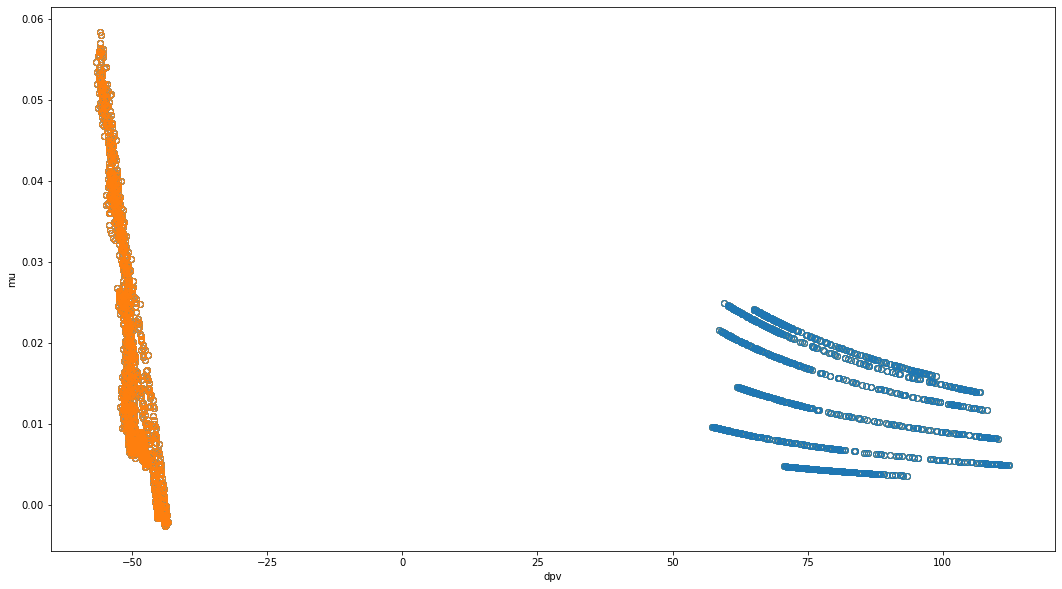

In [20]:
fig, ax = plt.subplots(1,figsize=(18,10))
for i in range(n_exp):
    ax.plot(x_train_top,  y_train_top, "o", fillstyle = "none")
    ax.plot(x_train_bot,  y_train_bot, "o", fillstyle = "none")
    ax.set_xlabel("dpv")
    ax.set_ylabel("mu")

# Training function

In [21]:


def training(x_train, y_train, nn_save_name = None, epochs = 2000, layers=2, width=10, batch_size=16):
    # normalize
    x_normalizer = UnitGaussianNormalizer(x_train)
    x_train = x_normalizer.encode(x_train)
    y_normalizer = UnitGaussianNormalizer(y_train)
    y_train = y_normalizer.encode(y_train)


    ind = x_train.shape[1]
    outd = y_train.shape[1] 


    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
    learning_rate = 0.001
    
    step_size = 100
    gamma = 0.5


    model = FNN(ind, outd, layers, width) 


    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    myloss = torch.nn.MSELoss(reduction='sum')
    t0 = default_timer()
    for ep in range(epochs):
        model.train()
        t1 = default_timer()
        train_l2 = 0
        for x, y in train_loader:

            optimizer.zero_grad()
            out = model(x)

            out = y_normalizer.decode(out)
            y = y_normalizer.decode(y)
            
#             if ep == epochs-1:
#                 print("out: ", out)
#                 print("y: ", y)
                

            loss = myloss(out , y)
            loss.backward()

            optimizer.step()
            train_l2 += loss.item()


        scheduler.step()

        if ep % 100 == 0:
            # train_l2/= ntrain
            t2 = default_timer()
            print("Epoch : ", ep, " Epoch time : ", t2-t1, " Train L2 Loss : ", train_l2)
    if nn_save_name is not None:
        torch.save(model, nn_save_name)
        torch.save(x_normalizer, nn_save_name + '.x_normalizer')
        torch.save(y_normalizer, nn_save_name + '.y_normalizer')

    print("Total time is :", default_timer() - t0, "Total epoch is ", epochs)
    
    return model, x_normalizer, y_normalizer


# Train top layer

In [22]:
x_train = torch.from_numpy(x_train_top.astype(np.float32))
y_train = torch.from_numpy(y_train_top.astype(np.float32))

model, x_normalizer, y_normalizer = training(x_train, y_train, 'top_layer.model', 2000, 2, 20, 64)


Epoch :  0  Epoch time :  0.2521077962592244  Train L2 Loss :  0.2325867936015129
Epoch :  100  Epoch time :  0.02921772003173828  Train L2 Loss :  0.050408947514370084
Epoch :  200  Epoch time :  0.029003819450736046  Train L2 Loss :  0.0505055645480752
Epoch :  300  Epoch time :  0.029704648070037365  Train L2 Loss :  0.05062937829643488
Epoch :  400  Epoch time :  0.02780170366168022  Train L2 Loss :  0.05068628187291324
Epoch :  500  Epoch time :  0.026503215543925762  Train L2 Loss :  0.0507133862702176
Epoch :  600  Epoch time :  0.025680439546704292  Train L2 Loss :  0.05072765506338328
Epoch :  700  Epoch time :  0.024837481789290905  Train L2 Loss :  0.05073408910539001
Epoch :  800  Epoch time :  0.02470699790865183  Train L2 Loss :  0.05073749669827521
Epoch :  900  Epoch time :  0.02486178372055292  Train L2 Loss :  0.050739235477522016
Epoch :  1000  Epoch time :  0.02587736863642931  Train L2 Loss :  0.05074000626336783
Epoch :  1100  Epoch time :  0.025155694223940372  T

# Prediction

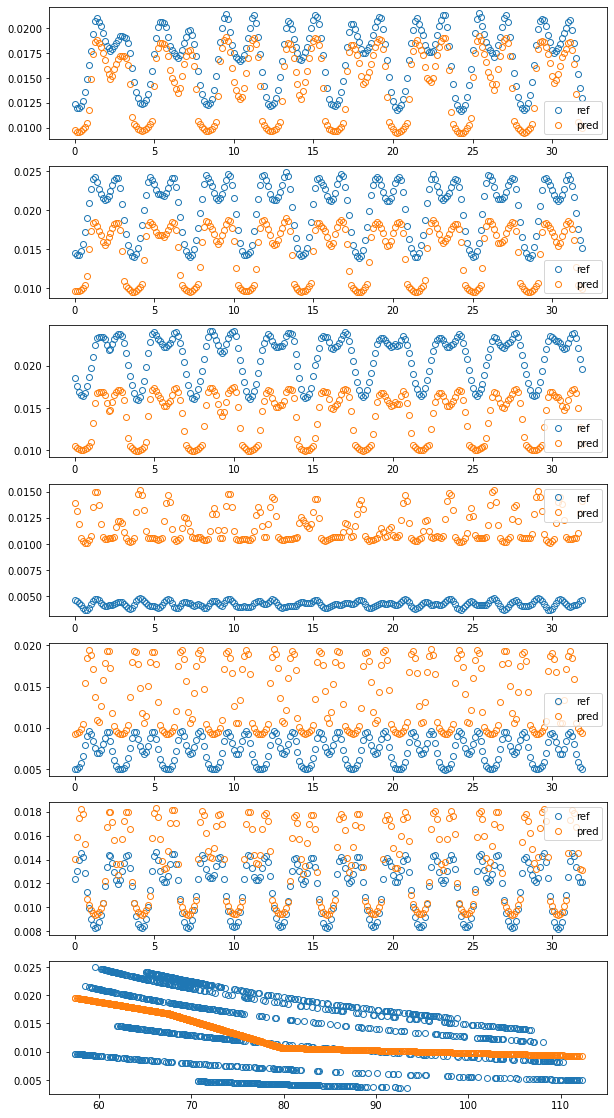

In [23]:
y_pred_train = y_normalizer.decode(model(x_normalizer.encode(x_train))).detach().numpy().flatten()
y_ref = y_train.numpy().flatten()


fig, ax = plt.subplots(n_exp + 1,figsize=(10,20))

ax[n_exp].plot(x_train, y_ref,  "o",  fillstyle = "none",  label="ref")
ax[n_exp].plot(x_train, y_pred_train,  "o",  fillstyle = "none",  label="pred")
# ax[n_exp].plot(x_normalizer.encode(x_train), y_normalizer.encode(y_train),  "-o",  fillstyle = "none",  label="ref")
# ax[n_exp].plot(x_normalizer.encode(x_train), y_normalizer.encode(torch.from_numpy(y_pred_train)),  "-o",  fillstyle = "none",  label="pred")
# ax[n_exp].legend()
    
for i in range(n_exp):
    ax[i].plot(yy, y_ref[i*nx:(i+1)*nx],         "o", fillstyle = "none", label="ref")
    ax[i].plot(yy, y_pred_train[i*nx:(i+1)*nx],  "o", fillstyle = "none", label="pred")
    ax[i].legend()
    


# Train bottom layer


In [24]:
x_train = torch.from_numpy(x_train_bot.astype(np.float32))
y_train = torch.from_numpy(y_train_bot.astype(np.float32))

model, x_normalizer, y_normalizer = training(x_train, y_train, 'bottom_layer.model', 2000, 2, 20, 64)


Epoch :  0  Epoch time :  0.03353464417159557  Train L2 Loss :  1.5390742644667625
Epoch :  100  Epoch time :  0.02946543414145708  Train L2 Loss :  0.04258781997486949
Epoch :  200  Epoch time :  0.029293429106473923  Train L2 Loss :  0.0426180767826736
Epoch :  300  Epoch time :  0.029282329604029655  Train L2 Loss :  0.0426298922393471
Epoch :  400  Epoch time :  0.028739147819578648  Train L2 Loss :  0.04262907535303384
Epoch :  500  Epoch time :  0.030713229440152645  Train L2 Loss :  0.042640262632630765
Epoch :  600  Epoch time :  0.029197664000093937  Train L2 Loss :  0.042638570768758655
Epoch :  700  Epoch time :  0.029849130660295486  Train L2 Loss :  0.04263530287425965
Epoch :  800  Epoch time :  0.029907068237662315  Train L2 Loss :  0.042631667107343674
Epoch :  900  Epoch time :  0.02938174456357956  Train L2 Loss :  0.04263014963362366
Epoch :  1000  Epoch time :  0.029121517203748226  Train L2 Loss :  0.042629380244761705
Epoch :  1100  Epoch time :  0.029385300353169

# Prediction

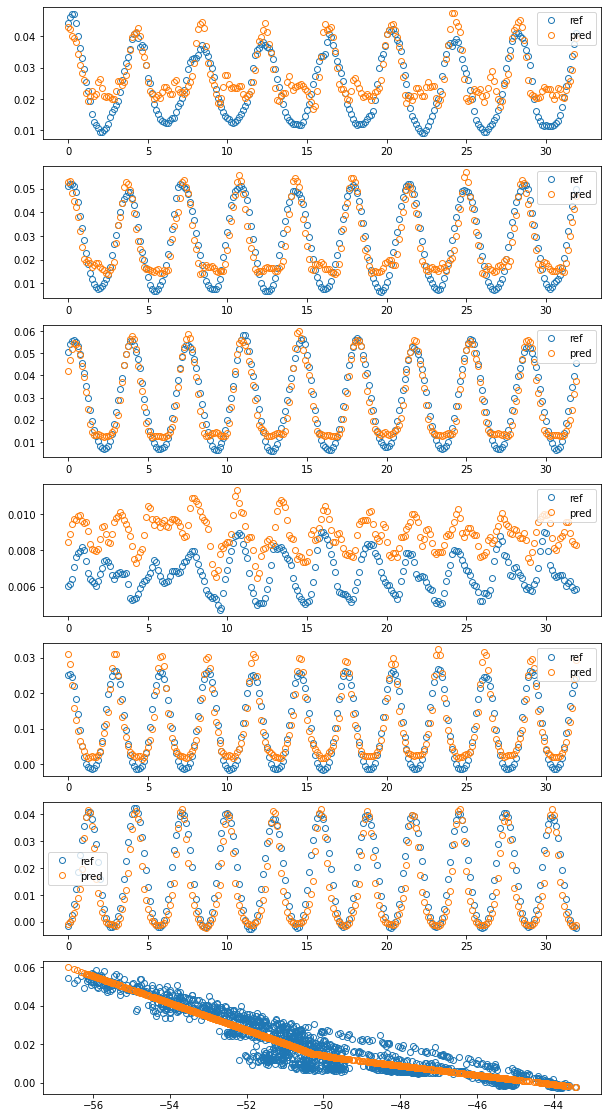

In [25]:
y_pred_train = y_normalizer.decode(model(x_normalizer.encode(x_train))).detach().numpy().flatten()
y_ref = y_train.numpy().flatten()

fig, ax = plt.subplots(n_exp + 1,figsize=(10,20))

ax[n_exp].plot(x_train, y_ref,  "o",  fillstyle = "none",  label="ref")
ax[n_exp].plot(x_train, y_pred_train,  "o",  fillstyle = "none",  label="pred")
# ax[n_exp].plot(x_normalizer.encode(x_train), y_normalizer.encode(y_train),  "-o",  fillstyle = "none",  label="ref")
# ax[n_exp].plot(x_normalizer.encode(x_train), y_normalizer.encode(torch.from_numpy(y_pred_train)),  "-o",  fillstyle = "none",  label="pred")
# ax[n_exp].legend()
    
for i in range(n_exp):
    ax[i].plot(yy, y_ref[i*nx:(i+1)*nx],         "o", fillstyle = "none", label="ref")
    ax[i].plot(yy, y_pred_train[i*nx:(i+1)*nx],  "o", fillstyle = "none", label="pred")
    ax[i].legend()